In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0" 
import ktrain
from ktrain import vision as vis

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-05-03 11:02:23--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.2.16, 2607:f8b0:400f:806::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.2.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  31.2MB/s    in 2.1s    

2020-05-03 11:02:25 (31.2 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [4]:
(trn, val, preproc) = vis.images_from_folder(
                                              datadir='/tmp/cats_and_dogs_filtered',
                                              data_aug = vis.get_data_aug(horizontal_flip=True),
                                              train_test_names=['train', 'validation'])

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
model = vis.image_classifier('pretrained_mobilenet', trn, val, freeze_layers=15)
learner = ktrain.get_learner(model=model, train_data=trn, val_data=val, 
                             workers=8, use_multiprocessing=False, batch_size=64)

The normalization scheme has been changed for use with a pretrained_mobilenet model. If you decide to use a different model, please reload your dataset with a ktrain.vision.data.images_from* function.

Is Multi-Label? False
pretrained_mobilenet model created.


simulating training for different learning rates... this may take a few moments...
Train for 31 steps
Epoch 1/3
31/31 [==============================] - 9s 282ms/step - loss: 1.9885 - accuracy: 0.4871
Epoch 2/3
31/31 [==============================] - 6s 196ms/step - loss: 2.3946 - accuracy: 0.8182
Epoch 3/3
 2/31 [>.............................] - ETA: 34s - loss: 56.5889 - accuracy: 0.4766 

done.
Visually inspect loss plot and select learning rate associated with falling loss


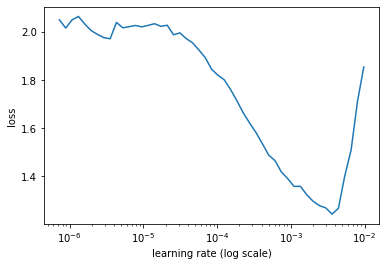

In [6]:
learner.lr_find(max_epochs=3, show_plot=True)

In [7]:
learner.fit_onecycle(1e-4, 4)



begin training using onecycle policy with max lr of 0.0001...
Train for 32 steps, validate for 32 steps
Epoch 1/4
32/32 [==============================] - 12s 361ms/step - loss: 1.3214 - accuracy: 0.6205 - val_loss: 0.2944 - val_accuracy: 0.9030
Epoch 2/4
32/32 [==============================] - 11s 341ms/step - loss: 0.5104 - accuracy: 0.8600 - val_loss: 0.1029 - val_accuracy: 0.9560
Epoch 3/4
32/32 [==============================] - 11s 359ms/step - loss: 0.2687 - accuracy: 0.9220 - val_loss: 0.0437 - val_accuracy: 0.9850
Epoch 4/4
32/32 [==============================] - 11s 356ms/step - loss: 0.2038 - accuracy: 0.9350 - val_loss: 0.0401 - val_accuracy: 0.9880


In [8]:
learner.validate(class_names=preproc.get_classes())

              precision    recall  f1-score   support

        cats       0.99      0.99      0.99       500
        dogs       0.99      0.99      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



array([[493,   7],
       [  5, 495]])

In [9]:
p = ktrain.get_predictor(learner.model, preproc)

In [10]:
p.predict_filename('/tmp/cats_and_dogs_filtered/validation/cats/cat.2001.jpg')

['cats']

In [11]:
p.predict_filename('/tmp/cats_and_dogs_filtered/validation/cats/cat.2001.jpg', return_proba=True)

array([[9.9993896e-01, 6.0984068e-05]], dtype=float32)

In [12]:
p.preproc.get_classes()

['cats', 'dogs']

In [13]:
p.save('/tmp/mycatsdogs')

In [14]:
p = ktrain.load_predictor('/tmp/mycatsdogs')

In [15]:
p.predict_filename('/tmp/cats_and_dogs_filtered/validation/dogs/dog.2001.jpg')

['dogs']

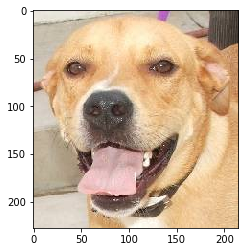

In [16]:
vis.show_image('/tmp/cats_and_dogs_filtered/validation/dogs/dog.2001.jpg')